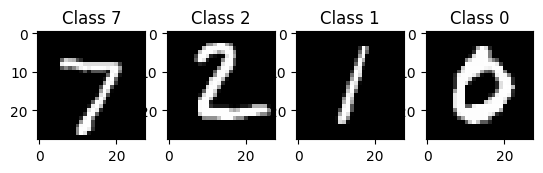

In [12]:
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt

from keras.datasets import mnist

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Add a channels dimension to the image sets as Akida expects 4-D inputs (corresponding to
# (num_samples, width, height, channels). Note: MNIST is a grayscale dataset and is unusual
# in this respect - most image data already includes a channel dimension, and this step will
# not be necessary.
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# Display a few images from the test set
f, axarr = plt.subplots(1, 4)
for i in range(0, 4):
    axarr[i].imshow(x_test[i].reshape((28, 28)), cmap=cm.Greys_r)
    axarr[i].set_title('Class %d' % y_test[i])
plt.show()

In [13]:
import keras

#creating the multlayer CNN, which will then be converted to a SNN.
model_keras = keras.models.Sequential([
    keras.layers.Rescaling(1. / 255, input_shape=(28, 28, 1)),
    keras.layers.Conv2D(filters=32, kernel_size=3, strides=2),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    # Separable layer
    keras.layers.DepthwiseConv2D(kernel_size=3, padding='same', strides=2),
    keras.layers.Conv2D(filters=64, kernel_size=1, padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.Flatten(),
    keras.layers.Dense(10)
], 'mnistnet')

model_keras.summary()

Model: "mnistnet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 28, 28, 1)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 32)        320       
                                                                 
 batch_normalization_2 (Batc  (None, 13, 13, 32)       128       
 hNormalization)                                                 
                                                                 
 re_lu_2 (ReLU)              (None, 13, 13, 32)        0         
                                                                 
 depthwise_conv2d_1 (Depthwi  (None, 7, 7, 32)         320       
 seConv2D)                                                       
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 64)          211

In [14]:
from keras.optimizers import Adam
#optimizes the algorithm to attain convergence. changing the learning rate
model_keras.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=Adam(learning_rate=1e-3),
    metrics=['accuracy'])

_ = model_keras.fit(x_train, y_train, epochs=10, validation_split=0.1)

Epoch 1/10
1688/1688 [==============================] - 8s 4ms/step - loss: 0.1760 - accuracy: 0.9476 - val_loss: 0.0673 - val_accuracy: 0.9812
Epoch 2/10
1688/1688 [==============================] - 7s 4ms/step - loss: 0.0718 - accuracy: 0.9779 - val_loss: 0.0630 - val_accuracy: 0.9833
Epoch 3/10
1688/1688 [==============================] - 7s 4ms/step - loss: 0.0546 - accuracy: 0.9826 - val_loss: 0.0630 - val_accuracy: 0.9832
Epoch 4/10
1688/1688 [==============================] - 7s 4ms/step - loss: 0.0417 - accuracy: 0.9863 - val_loss: 0.0656 - val_accuracy: 0.9843
Epoch 5/10
1688/1688 [==============================] - 7s 4ms/step - loss: 0.0357 - accuracy: 0.9887 - val_loss: 0.0797 - val_accuracy: 0.9783
Epoch 6/10
1688/1688 [==============================] - 7s 4ms/step - loss: 0.0280 - accuracy: 0.9907 - val_loss: 0.0552 - val_accuracy: 0.9873
Epoch 7/10
1688/1688 [==============================] - 7s 4ms/step - loss: 0.0238 - accuracy: 0.9917 - val_loss: 0.0789 - val_accuracy:

In [59]:
from quantizeml.models import quantize, QuantizationParams


qparams = QuantizationParams(input_weight_bits=2, weight_bits=2, activation_bits=2)
model_quantized = quantize(model_keras, qparams=qparams)
model_quantized.summary()

1024/1024 [==============================] - 1s 674us/step
Model: "mnistnet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1_input (InputLay  [(None, 28, 28, 1)]      0         
 er)                                                             
                                                                 
 rescaling_1 (QuantizedResca  (None, 28, 28, 1)        0         
 ling)                                                           
                                                                 
 conv2d_2 (QuantizedConv2D)  (None, 13, 13, 32)        320       
                                                                 
 re_lu_2 (QuantizedReLU)     (None, 13, 13, 32)        64        
                                                                 
 depthwise_conv2d_1 (Quantiz  (None, 7, 7, 32)         384       
 edDepthwiseConv2D)                                              

In [60]:
def compile_evaluate(model):
    """ Compiles and evaluates the model, then return accuracy score. """
    model.compile(metrics=['accuracy'])
    return model.evaluate(x_test, y_test, verbose=0)[1]


print('Test accuracy after 8-bit quantization:', compile_evaluate(model_quantized))

Test accuracy after 8-bit quantization: 0.29170000553131104


In [61]:
model_quantized = quantize(model_keras, qparams=qparams,
                           samples=x_train, num_samples=1024, batch_size=100, epochs=2)
#this is calibration

print('Test accuracy after calibration:', compile_evaluate(model_quantized))

11/11 [==============================] - 0s 4ms/step
Test accuracy after calibration: 0.11779999732971191


In [53]:
class Timer:
    def __init__(self):
        self.start_time = None
        self.end_time = None

    def start(self):
        self.start_time = time.perf_counter()

    def stop(self):
        self.end_time = time.perf_counter()
        return self.end_time - self.start_time

Prediction took 0.0004 seconds
Input Label: 7


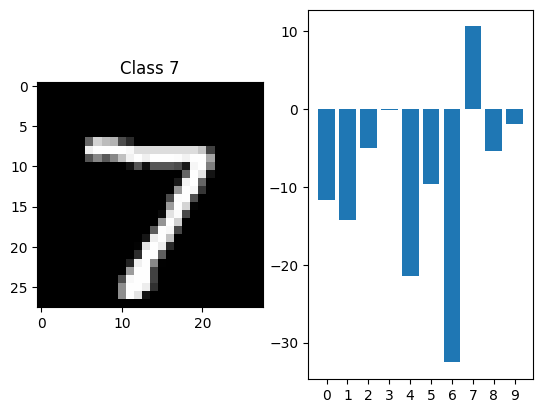

[-11.673607   -14.242352    -5.029101    -0.09616914 -21.491945
  -9.694143   -32.54855     10.577699    -5.38245     -1.9527236 ]


In [62]:
# Test a single example
sample_image = 0
image = x_test[sample_image]
timer = Timer()
timer.start()
outputs = model_akida.predict(image.reshape(1, 28, 28, 1))
prediction_time = timer.stop()
print(f"Prediction took {prediction_time:.4f} seconds")
print('Input Label: %i' % y_test[sample_image])

f, axarr = plt.subplots(1, 2)
axarr[0].imshow(x_test[sample_image].reshape((28, 28)), cmap=cm.Greys_r)
axarr[0].set_title('Class %d' % y_test[sample_image])
axarr[1].bar(range(10), outputs.squeeze())
axarr[1].set_xticks(range(10))
plt.show()

print(outputs.squeeze())